# 1. Install Dependencies and Setup

In [15]:
!pip uninstall opencv-python
!pip install opencv-python

^C
Defaulting to user installation because normal site-packages is not writeable


In [14]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [17]:
import cv2
import imghdr

C:\Users\arunm\AppData\Local\Temp\ipykernel_18660\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [18]:
data_dir = 'data' 

In [19]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [20]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [22]:
import numpy as np
from matplotlib import pyplot as plt

In [23]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [24]:
data_iterator = data.as_numpy_iterator()

In [25]:
batch = data_iterator.next()

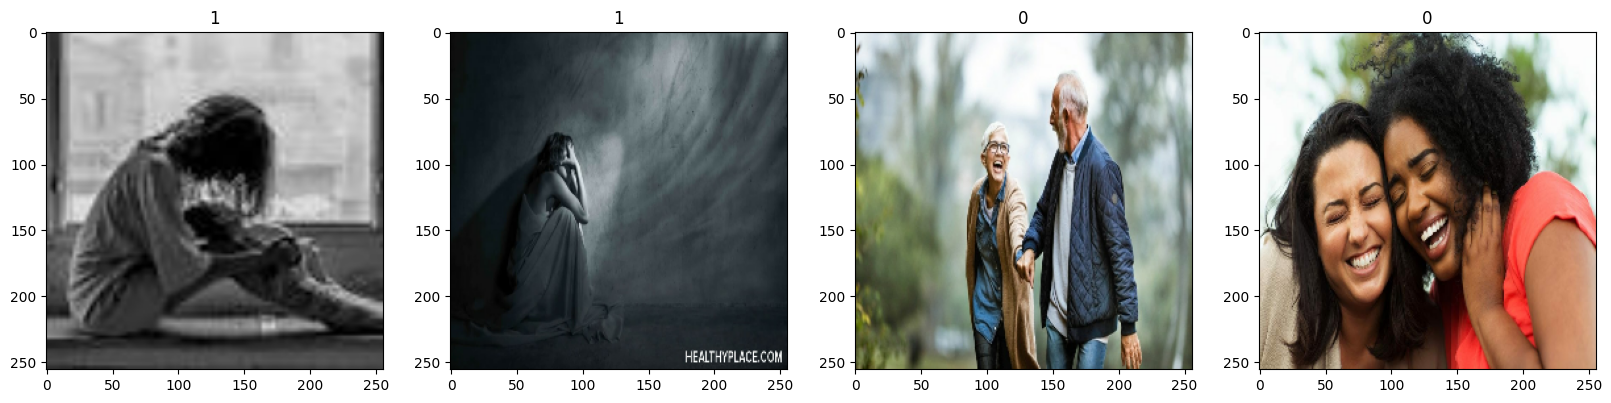

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [27]:
data = data.map(lambda x,y: (x/255, y))

In [28]:
data.as_numpy_iterator().next()

(array([[[[2.86274523e-01, 2.86274523e-01, 2.86274523e-01],
          [2.77512252e-01, 2.77512252e-01, 2.77512252e-01],
          [2.37683818e-01, 2.37683818e-01, 2.37683818e-01],
          ...,
          [2.44178921e-01, 2.44178921e-01, 2.44178921e-01],
          [1.30821079e-01, 1.30821079e-01, 1.30821079e-01],
          [1.05882354e-01, 1.05882354e-01, 1.05882354e-01]],
 
         [[2.85937488e-01, 2.85937488e-01, 2.85937488e-01],
          [2.77175248e-01, 2.77175248e-01, 2.77175248e-01],
          [2.37346813e-01, 2.37346813e-01, 2.37346813e-01],
          ...,
          [2.44002521e-01, 2.44002521e-01, 2.44002521e-01],
          [1.30513027e-01, 1.30513027e-01, 1.30513027e-01],
          [1.05545342e-01, 1.05545342e-01, 1.05545342e-01]],
 
         [[2.84405649e-01, 2.84405649e-01, 2.84405649e-01],
          [2.75643378e-01, 2.75643378e-01, 2.75643378e-01],
          [2.35814944e-01, 2.35814944e-01, 2.35814944e-01],
          ...,
          [2.43200690e-01, 2.43200690e-01, 2.4320

# 5. Split Data

In [29]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [30]:
train_size

7

In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [32]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [54]:
model = Sequential()
model.add(Input(shape=(256, 256, 3)))  # Use Input layer first
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    66,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,065,537 (252.02 MB)

 Trainable params: 66,065,537 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [57]:
logdir = "logs/scalars/"

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5306 - loss: 16.3890 - val_accuracy: 0.4844 - val_loss: 16.0167
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5582 - loss: 10.2799 - val_accuracy: 0.5000 - val_loss: 8.0658
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6247 - loss: 4.4853 - val_accuracy: 0.6406 - val_loss: 2.4097
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7396 - loss: 1.2583 - val_accuracy: 0.8281 - val_loss: 0.2650
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9184 - loss: 0.1848 - val_accuracy: 0.9531 - val_loss: 0.1219
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9498 - loss: 0.1305 - val_accuracy: 0.9531 - val_loss: 0.1786
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9493 - loss: 0.1823 - val_accuracy: 0.9688 - val_loss: 0.1268
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9815 - loss: 0.0984 - val_accuracy: 0.9531 - val_loss: 0.2330
Epoch 9/20
7

# 8. Plot Performance

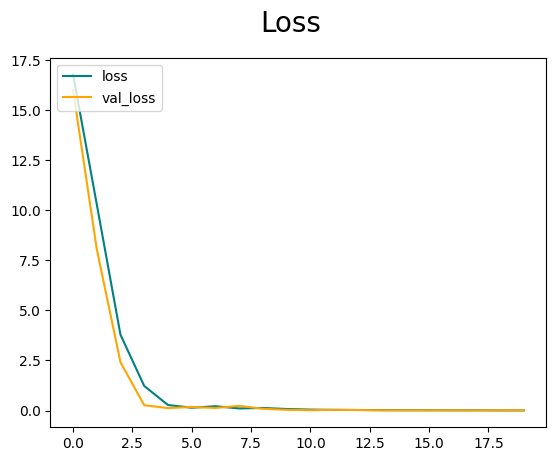

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

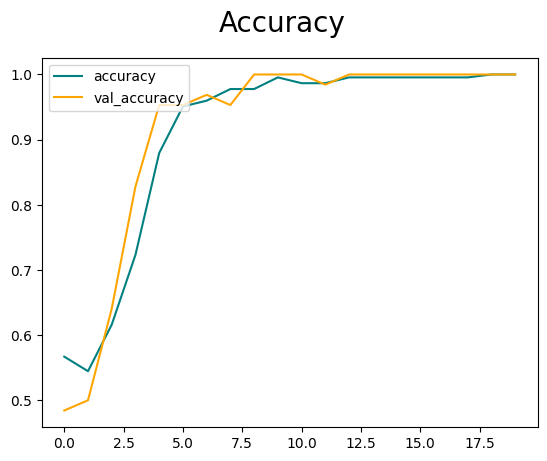

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [62]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [65]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [66]:
import cv2

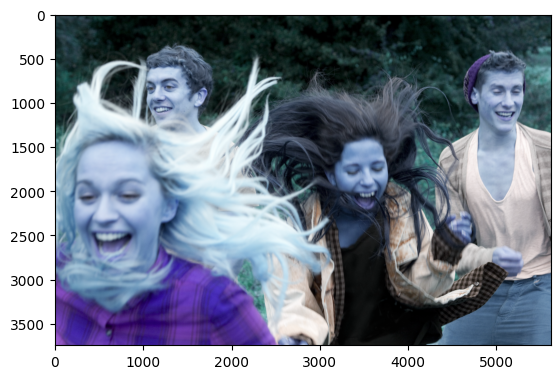

In [67]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

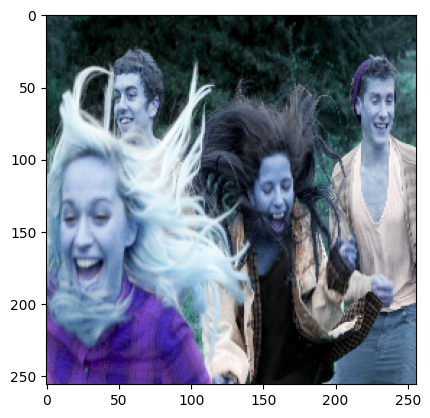

In [68]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [69]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [70]:
yhat

array([[0.00330719]], dtype=float32)

In [71]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [72]:
from tensorflow.keras.models import load_model

In [75]:
model.save(os.path.join('models', 'imageclassifier.keras'))

In [79]:
model = load_model(os.path.join('models', 'imageclassifier.keras'))

In [81]:
new_model.predict(np.expand_dims(resize/256, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[0.00350001]], dtype=float32)